## Estimating lifespan normative models

This notebook provides a complete walkthrough for an analysis of normative modelling using your own dataset. Training and testing data is provided for this tutorial. However, the idea is that you could subsitute our provided training and testing datasets for you own dataset (as long as it matches the same format!)

First, if necessary, we install PCNtoolkit (note: this tutorial requires at least version 0.20)

In [1]:
# Make sure to click the restart runtime button at the 
# bottom of this code blocks' output (after you run the cell)
! pip install pcntoolkit==0.28

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.0/570.0 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of sphinx to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 98.0 MB/s eta 0:00:00
  Created wheel for pcntoolkit: filename=pcntoolkit-0.28-py3-none-any.whl size=104392 sha256=58d2d10a0bd5358884c4445f3

Then we import the required libraries

In [2]:
! git clone https://github.com/CharFraza/CPC_ML_tutorial.git

Cloning into 'CPC_ML_tutorial'...
remote: Enumerating objects: 459, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 459 (delta 89), reused 154 (delta 73), pack-reused 282
Receiving objects: 100% (459/459), 14.90 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [3]:
# we need to be in the CPC_ML_tutorial folder when we import the libraries in the code block below,
# because there is a function called nm_utils that is in this folder that we need to import
import os
os.chdir('/content/CPC_ML_tutorial/')

In [4]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d

Now, we configure the locations in which the data are stored. 

**Notes:** 
- The data are assumed to be in CSV format and will be loaded as pandas dataframes
- Generally the raw data will be in a different location to the analysis
- The data can have arbitrary columns but some are required by the script, i.e. 'age', 'sex' and 'site', plus the phenotypes you wish to estimate (see below)

In [5]:
# where the raw data are stored
data_dir = '/content/CPC_ML_tutorial/data/'

# where the analysis takes place
root_dir = '/content/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

Now we load the data. 

We will load one pandas dataframe for the training set and one dataframe for the test set. We also configure a list of site ids.

In [6]:
df_tr = pd.read_csv(os.path.join(data_dir,'train_data.csv'), index_col=0) 
df_te = pd.read_csv(os.path.join(data_dir,'test_data.csv'), index_col=0)

# extract a list of unique site ids from the training set
site_ids =  sorted(set(df_tr['site'].to_list()))

### Configure which models to fit

Next, we load the image derived phenotypes (IDPs) which we will process in this analysis. This is effectively just a list of columns in your dataframe. Here we estimate normative models for the left hemisphere, right hemisphere and cortical structures.

In [8]:
# we choose here to process all idps. Uncomment lines 2-7 (and comment line 11) to run models for the whole brain, but we suggest just starting with several ROIs
#os.chdir(root_dir)
#!wget -nc https://raw.githubusercontent.com/CharFraza/CPC_ML_tutorial/master/data/task1_phenotypes.txt
#with open(os.path.join(root_dir,'task1_phenotypes.txt')) as f:
#  idp_ids = f.read().splitlines()
#for idx, ele in enumerate(idp_ids):
#        idp_ids[idx] = ele.replace('\t', '')

# we could also just specify a list of IDPs. Use this line to run just 2 models (not the whole brain)...this is a good place to start. If you have time,
# you can uncomment the above line and run the whole brain models. Be sure to comment out this line if you uncomment the above line. 
idp_ids = ['lh_MeanThickness_thickness', 'rh_MeanThickness_thickness']

File ‘task1_phenotypes.txt’ already there; not retrieving.



### Configure model parameters

Now, we configure some parameters for the regression model we use to fit the normative model. Here we will use a 'warped' Bayesian linear regression model. To model non-Gaussianity, we select a sin arcsinh warp and to model non-linearity, we stick with the default value for the basis expansion (a cubic b-spline basis set with 5 knot points). Since we are sticking with the default value, we do not need to specify any parameters for this, but we do need to specify the limits. We choose to pad the input by a few years either side of the input range. We will also set a couple of options that control the estimation of the model

For further details about the likelihood warping approach, see [Fraza et al 2021](https://www.biorxiv.org/content/10.1101/2021.04.05.438429v1).

In [10]:
# check the min & max age of the dataset, use this info to update the xmin & xmax variables in the code block below. 
df_tr['age'].describe()

count    1163.000000
mean       40.388727
std        17.235724
min        18.000000
25%        28.000000
50%        32.643395
75%        53.000000
max        87.000000
Name: age, dtype: float64

In [14]:
# which data columns do we wish to use as covariates? 
# You could add additional covariates from your own dataset here that you wish to use as predictors.
# However, for this tutorial today we will keep it simple and just use age & sex. 
# Maybe discuss with your partner ideas you have for other covariates you would like to include.
cols_cov = ['age','sex']

# which warping function to use? We can set this to None in order to fit a vanilla Gaussian noise model
warp =  'WarpSinArcsinh'
warp = None

# limits for cubic B-spline basis 
# check the min & max ages of the dataframes, add 5 to the max 
# and subtract 5 from the min and adjust these variables accordingly
xmin = 13 # set this variable
xmax = 92 # set this variable

# Do we want to force the model to be refit every time? 
# When training normative model from scratch like we are doing in this notebook (not re-using a pre-trained model), 
# this variable should be = True
force_refit = True 

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

### Fit the models

Now we fit the models. This involves looping over the IDPs we have selected. We will use a module from PCNtoolkit to set up the design matrices, containing the covariates, fixed effects for site and nonlinear basis expansion. 

In [15]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
   
    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te[idp].to_numpy()
    
    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]
    
    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
        
    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                p = 3, 
                                nknots = 5,
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te[cols_cov].loc[nz_te], 
                                site_ids = df_te['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                p = 3,
                                nknots = 5,
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'
        
        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'

Running IDP 0 lh_bankssts_thickness :
Estimating the normative model...
Processing data in /content/CPC_ML_tutorial/models/test/lh_bankssts_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 lh_caudalanteriorcingulate_thickness :
Estimating the normative model...
Processing data in /content/CPC_ML_tutorial/models/test/lh_caudalanteriorcingulate_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 lh_caudalmiddlefrontal_thickness :
Estimating the normative model...
Processing data in /content/CPC_ML_tutorial/models/test/lh_caudalmiddlefrontal_thickness/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


## Questions
1. Can you explain the covariance matrix and it's elements?
2. How do you change the order of the spline function?
3. How do you change the number of knots?


In [19]:
print(pd.DataFrame(X_te))

      0          1    2    3    4    5         6         7         8   \
0    1.0  80.169747  2.0  0.0  0.0  1.0  0.000000  0.000000  0.000000   
1    1.0  82.187543  1.0  0.0  0.0  1.0  0.000000  0.000000  0.000000   
2    1.0  82.187543  1.0  0.0  0.0  1.0  0.000000  0.000000  0.000000   
3    1.0  82.187543  1.0  0.0  0.0  1.0  0.000000  0.000000  0.000000   
4    1.0  82.187543  1.0  0.0  0.0  1.0  0.000000  0.000000  0.000000   
..   ...        ...  ...  ...  ...  ...       ...       ...       ...   
576  1.0  32.000000  2.0  1.0  0.0  0.0  0.000055  0.279467  0.572087   
577  1.0  23.000000  2.0  0.0  1.0  0.0  0.120313  0.592489  0.265564   
578  1.0  34.236824  2.0  0.0  0.0  1.0  0.000000  0.197682  0.595319   
579  1.0  26.929500  2.0  0.0  0.0  1.0  0.025596  0.491378  0.424553   
580  1.0  73.000000  1.0  1.0  0.0  0.0  0.000000  0.000000  0.000000   

           9         10        11        12  
0    0.035820  0.341190  0.558509  0.064481  
1    0.020440  0.257845  0.5943

### Compute error metrics

In this section we compute the following error metrics for all IDPs (all evaluated on the test set): assess the goodness of fit between the predicted probabilities of a model and the actual observed outcomes.
- Negative log likelihood (NLL): NLL assesses the goodness of fit between the predicted probabilities of a model and the actual observed outcomes. In this case, it measures the discrepancy between the predicted probabilities of the model for the IDPs (Independent Data Points) and the actual outcomes on the test set.
- Explained variance (EV): EV assesses how much of the total variation in the dependent variable (IDP) is explained by the independent variables. In the context of this analysis, it quantifies the extent to which the independent variables account for the variability observed in the IDPs on the test set.
- Mean standardized log loss (MSLL): MSLL takes into account both the mean error and the estimated prediction variance. It is used to evaluate the performance of the model, and in this case, a lower MSLL indicates a better-fitting model for the IDPs on the test set.
- Bayesian information criteria (BIC): BIC is a model selection criterion that balances the goodness of fit to the data with the model's complexity. It penalizes models with higher flexibility and aims to find the best trade-off. Lower BIC scores indicate models that better explain the IDPs on the test set while considering the model complexity.
- Skew and Kurtosis of the Z-distribution: Skewness and kurtosis are statistical measures used to assess the shape and characteristics of a distribution. They provide information about how well the warping function performed in terms of capturing the departure from a normal distribution for the IDPs.

For more information on the different model selection criteria see [Fraza et al 2021](https://www.biorxiv.org/content/10.1101/2021.04.05.438429v1)

In [21]:
# initialise dataframe we will use to store quantitative metrics 
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]
    
display(blr_metrics)

blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,lh_bankssts_thickness,-538.280931,0.186925,-0.290735,-1062.446065,-0.780953,4.548628
1,lh_caudalanteriorcingulate_thickness,-125.223123,0.050390,-0.784159,-236.330450,-0.008032,1.092531
2,lh_caudalmiddlefrontal_thickness,-625.929323,0.315902,-0.530062,-1237.742850,0.196900,0.888073
3,lh_cuneus_thickness,-587.861754,0.421739,-12.947138,-1161.607712,0.074074,0.601695
4,lh_entorhinal_thickness,128.705644,0.198267,-23.526863,271.527084,0.137293,0.624941
...,...,...,...,...,...,...,...
65,rh_frontalpole_thickness,-32.553910,0.054162,-2.945091,-50.992023,-0.006967,0.563570
66,rh_temporalpole_thickness,276.156139,0.121448,-44.140173,566.428073,-0.616807,0.734628
67,rh_transversetemporal_thickness,-89.939762,0.523787,-2.625758,-165.763729,-0.285784,1.558589
68,rh_insula_thickness,-489.255240,0.249095,-6.855180,-964.394685,-0.901408,6.496121


In [22]:
blr_metrics['EV'].describe()

count    70.000000
mean      0.260980
std       0.161654
min      -0.030862
25%       0.115135
50%       0.252887
75%       0.362133
max       0.727994
Name: EV, dtype: float64

In [23]:
blr_metrics['MSLL'].describe()

count    70.000000
mean     -4.872836
std       8.243549
min     -44.140173
25%      -4.701348
50%      -1.849120
75%      -0.615530
max      -0.175120
Name: MSLL, dtype: float64

<Axes: >

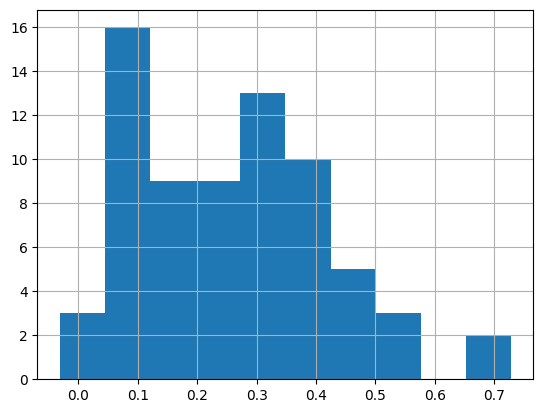

In [24]:
blr_metrics['EV'].hist()

<Axes: >

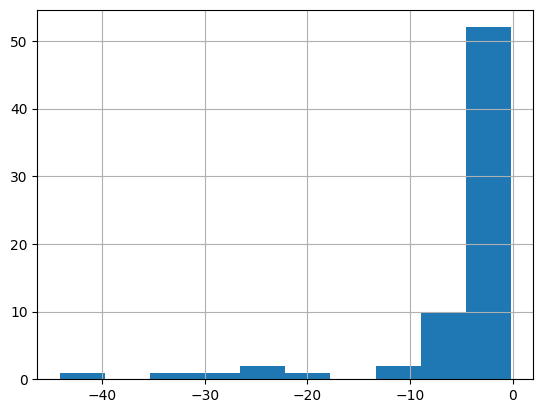

In [25]:
blr_metrics['MSLL'].hist()

## Questions to discuss
1. Model selection: Which model selection criteria would you use to choose the optimal model?
2. Model flexibility: What happens when you change the warping or B-spline settings?
3. Bias-variance tradeoff: How would you consider the bias-variance tradeoff when deciding the models parameters?
4. Which independent variables do you think are important to add to the normative model?
5. Are there other model selection criteria that you think should be considered?

## Suggested further readings

1. [PCNtoolkit Background](https://pcntoolkit.readthedocs.io/en/latest/pages/pcntoolkit_background.html)
2. [Conceptualizing mental disorders as deviations from normative functioning](https://www.nature.com/articles/s41380-019-0441-1)
3. [Understanding Heterogeneity in Clinical Cohorts Using Normative Models: Beyond Case-Control Studies
](https://www.sciencedirect.com/science/article/pii/S0006322316000020)
